In [155]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pyomo.environ as pyo

In [156]:
from load_data import get_load_data, get_gen_data, get_spot_prices_data

In [157]:
load_max = 5e3
gen_max = 50e3
index = 45

In [158]:
load = get_load_data(index)[:96] * load_max
load

,pload,qload
0,580.850,1271.06
1,612.245,1271.06
2,580.850,1271.06
3,580.850,1290.92
4,573.000,1211.48
...,...,...
91,408.165,1231.34
92,392.465,1271.06
93,384.615,1231.34
94,361.070,1231.34


In [159]:
time = np.array(load.index)
time

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

In [160]:
sload = np.sqrt(load.pload**2 + load.qload**2)

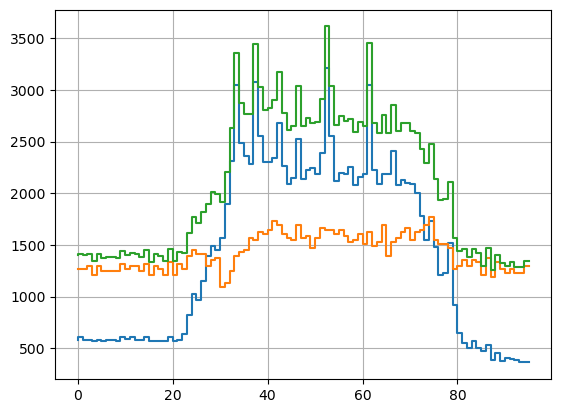

In [161]:

plt.step(time, load.pload, time, load.qload, time, sload)
plt.grid(True)

In [162]:
pv_gen = get_gen_data(index)[:96] * gen_max

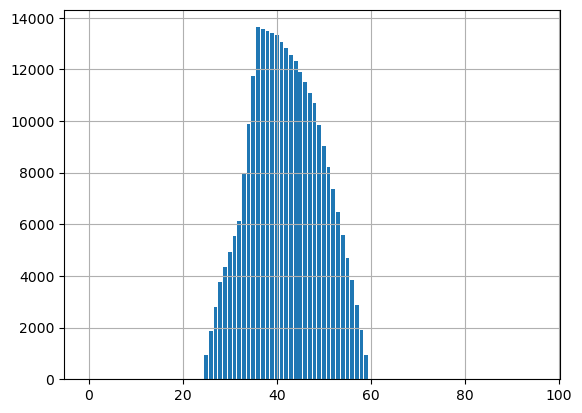

In [163]:
plt.bar(time, pv_gen.pgen)
plt.grid(True)

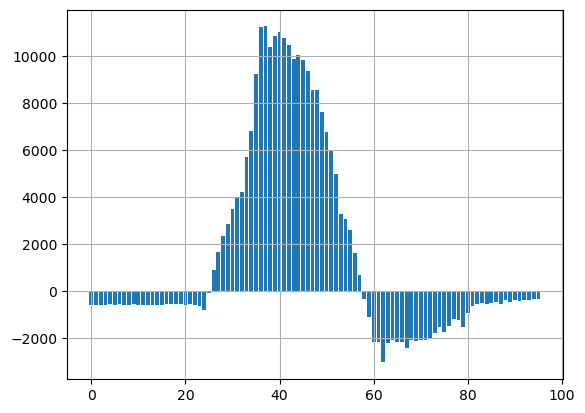

In [164]:
net_demand = pv_gen.pgen - load.pload
plt.bar(time, net_demand)
plt.grid(True)

In [165]:
spot_price = get_spot_prices_data(30)[:96]

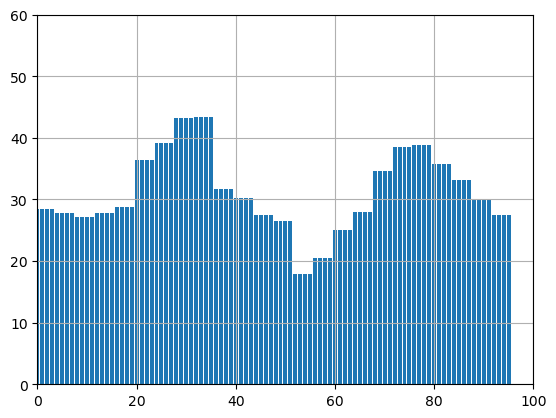

In [166]:
plt.bar(time, spot_price.Price)
plt.xlim((0.0, 100.0))
plt.ylim((0.0, 60.0))
plt.grid(True)

In [167]:
a = 0.0
b = 5.0
T = 100.0
h2v_prices = 60.0 * np.sin(2.0 * np.pi * 1/T * time)**2 + (a + (b - a) * np.random.rand(time.size))

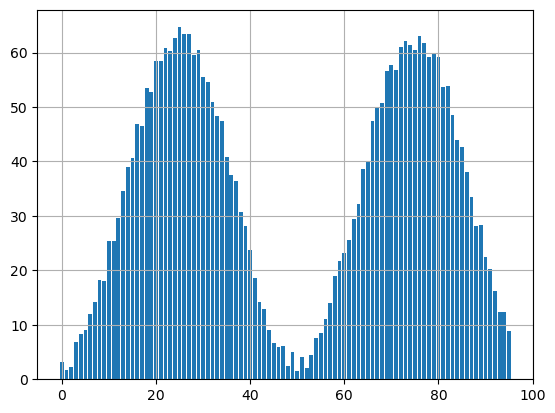

In [168]:
plt.bar(time, h2v_prices)
plt.grid(True)

In [169]:
model = pyo.ConcreteModel(name="H2V")

model.time_set = pyo.Set(initialize=time)

model.param_load = pyo.Param(model.time_set, initialize=load.pload.values, mutable=True)
model.param_pv_gen = pyo.Param(model.time_set, initialize=pv_gen.pgen.values)
model.param_spot_prices = pyo.Param(model.time_set, initialize=spot_price.Price)
model.param_h2v_prices = pyo.Param(model.time_set, initialize=h2v_prices)

model.var_power_to_market = pyo.Var(model.time_set, domain=pyo.PositiveReals)
model.var_power_to_h2v = pyo.Var(model.time_set, domain=pyo.PositiveReals)
model.var_power_from_grid = pyo.Var(model.time_set, domain=pyo.PositiveReals)

In [170]:
# Função Objetivo
def obj_function(model):
    y = list() 
    for t in time:
        aux = model.param_spot_prices[t] * model.var_power_to_market[t] + model.param_h2v_prices[t] * model.var_power_to_h2v[t] - model.param_spot_prices[t] * model.var_power_from_grid[t]
        y.append(aux)
    return sum(y)
model.cost_function = pyo.Objective(rule=obj_function, sense=pyo.maximize)

In [171]:
# restrição de balanço energético
def constraint_market(model, t):
    return model.var_power_to_market[t] + model.var_power_to_h2v[t] <= model.param_pv_gen[t]

model.constraint_market = pyo.Constraint(model.time_set, rule=constraint_market)

def constraint_load(model, t):
    return model.param_pv_gen[t] + model.var_power_from_grid[t] >= model.param_load[t]

model.constraint_load = pyo.Constraint(model.time_set, rule=constraint_load)

In [172]:
# ----------------------------------
# Solving the model
# ----------------------------------
solver = pyo.SolverFactory('cplex')
results = solver.solve(model)
if (results.solver.status == pyo.SolverStatus.ok) and (results.solver.termination_condition == pyo.TerminationCondition.optimal):
    print ("this is feasible and optimal")
elif results.solver.termination_condition == pyo.TerminationCondition.infeasible:
    print ("do something about it? or exit?")
else:
    # something else is wrong
    print (str(results.solver))

this is feasible and optimal


In [173]:
pyo.value(model.cost_function)

7441352.929529849

In [174]:
power_to_market_array = np.array(list(model.var_power_to_market.get_values().values()))
power_to_market_array

array([    0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   ,     0.   , 11754.4  ,
           0.   ,     0.   , 13480.5  , 13406.   , 13331.5  , 13077.7  ,
       12823.9  , 12570.1  , 12316.25 , 11910.8  , 11505.3  , 11099.8  ,
       10694.35 ,  9863.9  ,  9033.45 ,  8203.   ,  7372.55 ,  6486.   ,
        5599.5  ,  4712.965,  3826.435,  2869.825,  1913.215,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   , 

In [175]:
power_to_h2v_array = np.array(list(model.var_power_to_h2v.get_values().values()))
power_to_h2v_array

array([    0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,   937.125,  1874.245,  2811.37 ,  3748.495,  4343.67 ,
        4938.84 ,  5534.   ,  6129.2  ,  8004.25 ,  9879.35 ,     0.   ,
       13629.5  , 13555.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   ,     0.   ,   956.61 ,
           0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   , 

In [176]:
power_from_grid = np.array(list(model.var_power_from_grid.get_values().values()))
power_from_grid

array([ 580.85 ,  612.245,  580.85 ,  580.85 ,  573.   ,  580.85 ,
        573.   ,  580.85 ,  580.85 ,  565.15 ,  604.395,  588.695,
        604.395,  580.85 ,  580.85 ,  612.245,  565.15 ,  573.   ,
        573.   ,  573.   ,  612.245,  573.   ,  580.85 ,  635.795,
        816.325,   83.285,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,  339.53 , 1123.455,
       2158.555, 2182.105, 3045.525, 2229.2  , 2087.91 , 2182.105,
       2182.105, 2409.735, 2080.065, 2127.16 , 2103.61 , 2087.91 ,
       2001.57 , 1781.79 , 1546.31 , 1734.695, 1475.665, 1208.79 ,
       1224.49 , 1514.915,  918.365,  643.64 ,  549.45 ,  502.355,
        565.15 ,  502.355,  470.96 ,  533.75 ,  384.615,  455.

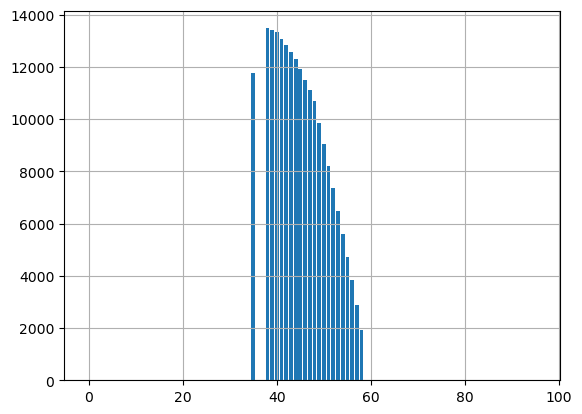

In [177]:
plt.bar(time, power_to_market_array)
plt.grid(True)

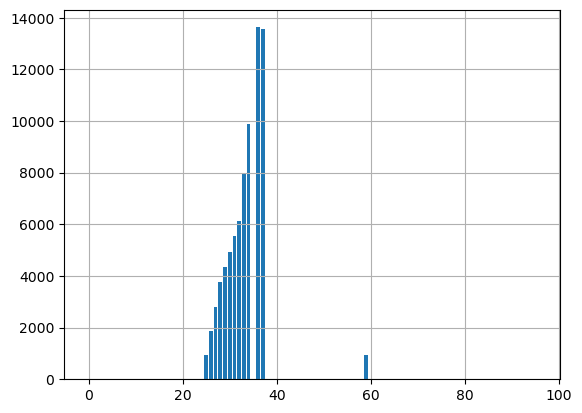

In [181]:
plt.bar(time, power_to_h2v_array)
plt.grid(True)

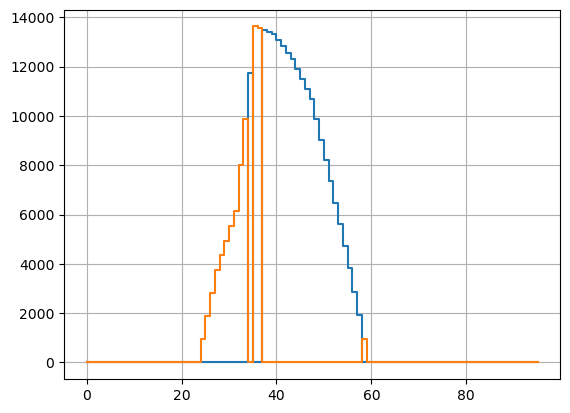

In [178]:
plt.step(time, power_to_market_array, time, power_to_h2v_array)
plt.grid(True)

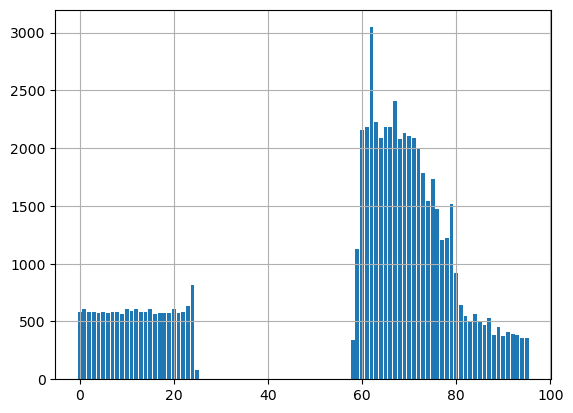

In [180]:
plt.bar(time, power_from_grid)
plt.grid(True)